### Shapes Dataset
We present the "shapes dataset" consisting of a training set of 60,000 examples, and a test set of 10,000 examples. Each example is a 784-dimensional vector, which when reformatted as an image has the appearance of one of 3 shapes - triangle, square or pizza.

Four flat binary data files are available on this site:

Shapes_1_1_Train_Features.dat: training set features (47040000 bytes) 
Shapes_1_1_Train_Labels.dat: training set labels (60000 bytes) 
Shapes_1_1_Test_Features.dat: training set features (7840000 bytes) 
Shapes_1_1_Test_Labels.dat: training set labels (10000 bytes)

Once you import a feature file by reading in all the bytes, you must partition the data into lists of 784 elements. Each of these lists can be viewed as an image of a handwritten digit by reformatting it as a 28x28 matrix.
Questions? Email: shashi@numericinsight.com
www.numericinsight.com

### Supervised learning model - for Small images using Logistic Regression

In [42]:
import os, struct
import matplotlib as plt
from array import array as pyarray
import pandas as pd
from openpyxl import load_workbook
from pylab import *
from numpy import *
import numpy.linalg as LA

from sklearn import linear_model
from numpy.linalg import inv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

### Load Training dataset

In [43]:
def load_NMNIST(dataset="training", digits=range(10), path=r'/Users/monikabansal/ucsc/MachineLearning/project/shapes_data'):
    
    if dataset == "training":
        fname_img = os.path.join(path, 'Shapes_1_1_Train_Features.dat')
        fname_lbl = os.path.join(path, 'Shapes_1_1_Train_Labels.dat')
    elif dataset == "testing":
        fname_img = os.path.join(path, 'Shapes_1_1_Test_Features.dat')
        fname_lbl = os.path.join(path, 'Shapes_1_1_Test_Labels.dat')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    lbl = np.fromfile(flbl, dtype=np.uint8)
    flbl.close()

    fimg = open(fname_img, 'rb')
    img = np.fromfile(fimg, dtype=np.uint8)
    fimg.close()

    size=len(lbl)

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    rows=28;cols=28;

    images = zeros((N, rows, cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]
    return images, labels

In [44]:
def vectortoimg(v,show=True):
    #vReshaped = v.reshape(28,28)
    #print("vReshaped", vReshaped.shape, vReshaped)
    plt.imshow(v.reshape(28, 28),interpolation='None', cmap='gray')
    plt.axis('off')
    if show:
        plt.show()

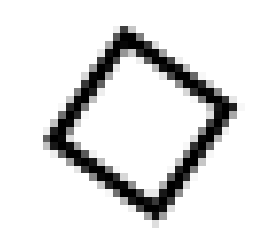

X: (60000, 784)
T: (60000, 1)


In [45]:
images, labels = load_NMNIST('training', digits=[0,1,2])

flatimages = list()
for i in images:
    flatimages.append(i.ravel())
X = asarray(flatimages) # X now contains 60000 feature vectors, each of dimension 784
T=labels # T contains class labels with 0->Triangle, 1->Square, 2->Pizza
vectortoimg(X[18])

print("X:" , X.shape)#, X[20:22,300:400])
print("T:" , T.shape)#, T)


Checking multiple training vectors by plotting images.
Be patient:


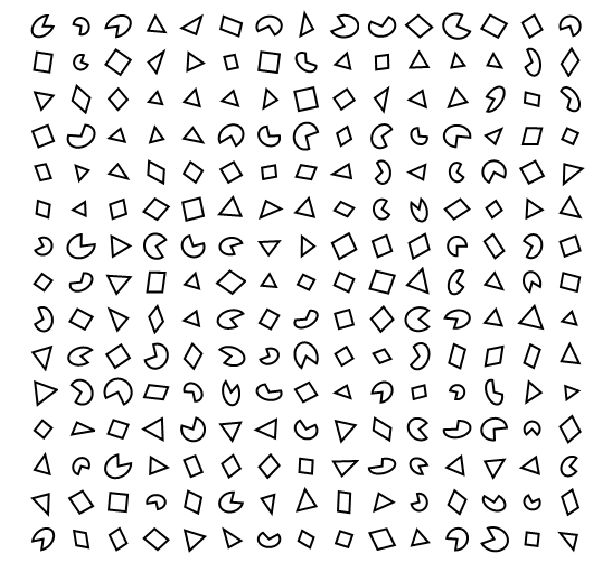

In [22]:
print("Checking multiple training vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure(figsize=(10,10))
nrows=15
ncols=15
for row in range(nrows):
    for col in range(ncols):
        #print("row*ncols+col + 1", row*ncols+col + 1)
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        vectortoimg(X[row*ncols+col + 1],show=False)
        #vectortoimg(X[np.random.randint(len(T))],show=False)
plt.show()

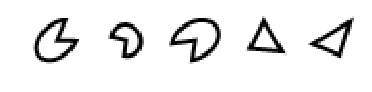

In [23]:
#Checking multiple training vectors by plotting images
def vectortoimgMlt(X,T,nrows,ncols):
    plt.close('all')
    fig = plt.figure()
    for row in range(nrows):
        for col in range(ncols):
            plt.subplot(nrows, ncols, row*ncols+col + 1)
            vectortoimg(X[row*ncols+col + 1],show=False)          
            #vectortoimg(X[np.random.randint(len(T))],show=False)
    plt.show()
    
vectortoimgMlt(X,T,1,5) # plot first 1 to 5

### Load Testing dataset

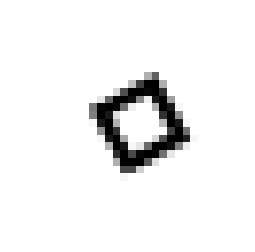

Xt: (10000, 784)
Tt: (10000, 1)


In [24]:
images, labels = load_NMNIST('testing', digits=[0,1,2])

flatimages = list()
for i in images:
    flatimages.append(i.ravel())
Xt = asarray(flatimages) # X now contains 60000 feature vectors, each of dimension 784
Tt = labels # T contains class labels with 0->Triangle, 1->Square, 2->Pizza
vectortoimg(Xt[8])

print("Xt:" , Xt.shape)#, X[20:22,300:400])
print("Tt:" , Tt.shape)#, T)

In [25]:
def vectortoimgRed(v,show=True):
    #vReshaped = v.reshape(14,14)
    #print("vReshaped", vReshaped.shape, vReshaped)
    #plt.imshow(v.reshape(14, 14),interpolation='None', cmap='gray')
    plt.imshow(v.reshape(15, 15),interpolation='None', cmap='gray')
    plt.axis('off')
    if show:
        plt.show()

In [26]:
# Get count of blank number of rows and columns to identify Small Images


def getBlankRowColCount(v):
    vReshaped = v.reshape(28,28)
    blkRowCount = 0
    for row in range(28):
        #print("sum(vReshaped[row]):", sum(vReshaped[row]), 255*28, row, vReshaped[row])
        if(sum(vReshaped[row])) == 255*28:
            blkRowCount = blkRowCount + 1
            
    blkColCount = 0       
    for col in range(28):
        if(sum(vReshaped[:,col])) == (255*28):
            blkColCount = blkColCount + 1
    
    #print("blkRowCount, blkColCount:", blkRowCount, blkColCount)   
    
    return [blkRowCount , blkColCount]


In [27]:
print("blkRowCount:" , getBlankRowColCount(Xt[8])) # 7, 8, 14, 16, 17, 19


blkRowCount: [14, 14]


blkRowColCount: 14 14


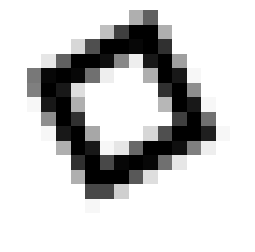

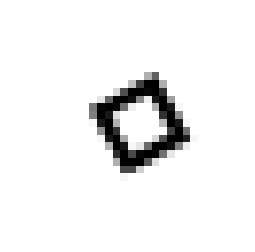

In [28]:
# Get count of blank number of rows and columns to identify Small Images
def getReducedSmallerImages(v):
    vReshaped = v.reshape(28,28)
    #print("Before reducing 28x28:")
    #print(vReshaped)
    blkRowCount = 0
    vRed = []
    for row in range(28):
        #print("sum(vReshaped[row]):", sum(vReshaped[row]), 255*28, row, vReshaped[row])
        if(sum(vReshaped[row])) == 255*28:
            blkRowCount = blkRowCount + 1
        else:
            vRed.append(vReshaped[row])
            
    
    # Go through each col in vReshaped and create new feature array with non blank columns
    blkColCount = 0  
    colInd = []
    for col in range(28):
        if(sum(vReshaped[:,col])) == (255*28):
            blkColCount = blkColCount + 1
        else:
            colInd.append(col) # non blank col Indexes
    
    # create reduced feature vector
    #print("colInd:", colInd)
    vReduce = []
    for i,bi in enumerate(vRed):
        newRow = []
        for j,bj in enumerate(colInd):
            newRow.append(bi[bj])
        vReduce.append(newRow)
    
    #print("vReduce:", np.array(vReduce).shape, vReduce)
    #print("blkRowCount, blkColCount:", blkRowCount, blkColCount)   
    
    # create reduced 14x14 feature vector
    vReduce14 = np.zeros((15,15)).astype('int32');
    vReduce14.fill(255)
    
    rCnt = np.size(vReduce,0)
    cCnt = np.size(vReduce,1)
    #print("vReduce: ", rCnt, cCnt)
    
    for i in range(rCnt):
        for j in range(cCnt):
            vReduce14[i][j] = vReduce[i][j]
    
    #print("vReduce14:", vReduce14.shape, vReduce14)
    vRed196 = vReduce14.reshape(225)#196)
    #print("vRed196", vRed196.shape, vRed196)
    #print("After reducing 15x15")
    #print(vRed196.reshape(15,15))
    return [blkRowCount + blkColCount, vRed196]


[rCnt,cCnt] = getBlankRowColCount(Xt[8])

print("blkRowColCount:" , rCnt , cCnt) # 7, 8, 14, 16, 17, 19

if(rCnt > 12 and cCnt > 12):  # Its smaller image
    [blkRowColCount, Xtr8] = getReducedSmallerImages(Xt[8])
    #print("blkRowColCount:" , blkRowColCount, Xtr8) # 7, 8, 14, 16, 17, 19

# Plot reduced image
vectortoimgRed(Xtr8)
vectortoimg(Xt[8])

### Separate all small and large images from Test set

In [29]:
# Collect all small images from Test set
Xtsm = []
Ttsm = []
Xtlg = []
Ttlg = []

print("Xt:",len(Xt))
print("Tt:",len(Tt))

for img in range(10000):
    [rCnt,cCnt] = getBlankRowColCount(Xt[img])
    if(rCnt > 12 and cCnt > 12): # Its smaller image
        [rCcntx, Xts] = getReducedSmallerImages(Xt[img])
        Xtsm.append(Xts) #Xt[img])
        Ttsm.append(Tt[img])
    else:
        Xtlg.append(Xt[img])
        Ttlg.append(Tt[img])

        
print("Xtsm:",len(Xtsm)) # 4121 / 10,000
print("Ttsm:",len(Ttsm))

print("Xtlg:",len(Xtlg)) # 5879/ 10,000
print("Ttlg:",len(Ttlg))


# Temporarily setting to small images
Xt = np.array(Xtsm)
Tt = np.array(Ttsm)
print("Xt:",Xt.shape)
print("Tt:",Tt.shape)

Xt: 10000
Tt: 10000
Xtsm: 4121
Ttsm: 4121
Xtlg: 5879
Ttlg: 5879
Xt: (4121, 225)
Tt: (4121, 1)


### Separate all small and large images from Training set

In [30]:
# Collect all small images from Training set
Xsm = []
Tsm = []
Xlg = []
Tlg = []
for img in range(60000):        
    [rCnt,cCnt] = getBlankRowColCount(X[img])
    if(rCnt > 12 and cCnt > 12):
        [rCcntx, Xs] = getReducedSmallerImages(X[img])
        Xsm.append(Xs) #X[img])
        Tsm.append(T[img])
    else:
        Xlg.append(X[img])
        Tlg.append(T[img])

print("Xsm:",len(Xsm)) # 717 / 60,000
print("Tsm:",len(Tsm))

print("Xlg:",len(Xlg)) # 59283 / 10,000
print("Tlg:",len(Tlg))

# Temporarily setting to small images 
X = np.array(Xsm)
T = np.array(Tsm)
print("X:",X.shape)
print("T:",T.shape)

Xsm: 717
Tsm: 717
Xlg: 59283
Tlg: 59283
X: (717, 225)
T: (717, 1)


In [32]:
# Split result into classes - upto 5 classes

def splitDataIntoClasses(P,T):
    P1 = []
    P2 = []
    P3 = []       
    P4 = []
    P5 = []
    for i,j in enumerate(P):
        #print("i=",i , " j= ",j,"X[i]=", X[i])
        if(T[i] == 0) : 
            P1.append(j)
        elif(T[i] == 1) : 
            P2.append(j)
        elif(T[i] == 2) : 
            P3.append(j)
        elif(T[i] == 3) : 
            P4.append(j)
        else :
            P5.append(j)
    return(np.array(P1),np.array(P2),np.array(P3),np.array(P4),np.array(P5)) 

### Reduce Training set from 225 dims to fewer Principal Component dims

In [33]:

scaler = StandardScaler()

# Fit on training set only
scaler.fit(X)

# Apply transform to both the training set 
train_img = scaler.transform(X) # Training Image

# Make an instance of the Model
pca = PCA(.95)

# Fit PCA on Training set only
pca.fit(X)

print("Number of components choosen:" , pca.n_components_) #133
#print("Explained Variance:" , pca.explained_variance_)
print("Explained Variance Total:" , sum(pca.explained_variance_ratio_)) # 95%
#print("Explained Variance Ratio:" , pca.explained_variance_ratio_)

# 95% of the variance amounts to 134 principal components.

# Transform Training set
Xpca = pca.transform(X)

print("Xpca:", Xpca.shape)


Number of components choosen: 30
Explained Variance Total: 0.9527839522876204
Xpca: (717, 30)


/Users/monikabansal/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Reduce Testset from 225 dims to fewer Principal Component dims

In [34]:

scaler = StandardScaler()

# Fit on training set only
scaler.fit(Xt)

# Apply transform to the test set
test_img = scaler.transform(Xt) # Testing Image

# Make an instance of the Model
#pca = PCA(.95)
pca = PCA(n_components=30, svd_solver='full')

# Fit PCA on Training set only
pca.fit(Xt)

print("Number of components choosen:" , pca.n_components_) #133
#print("Explained Variance:" , pca.explained_variance_)
print("Explained Variance Total:" , sum(pca.explained_variance_ratio_)) # 95%
#print("Explained Variance Ratio:" , pca.explained_variance_ratio_)

# 95% of the variance amounts to 54 principal components.

# Transform  Test set
Xtpca = pca.transform(Xt)

print("Xtpca:", Xtpca.shape)


Number of components choosen: 30
Explained Variance Total: 0.8740003021735574
Xtpca: (4121, 30)


/Users/monikabansal/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Reduce to 2 PCA components in Test set - for plotting

In [35]:
pca2 = PCA(n_components=2, svd_solver='full')

# Fit PCA on Training set only
pca2.fit(Xt)

print("Number of components choosen:" , pca2.n_components_) #133
print("Explained Variance Total:" , sum(pca2.explained_variance_ratio_)) # 95%
#print("Explained Variance Ratio:" , pca2.explained_variance_ratio_)

# 22% of the variance amounts to 2 principal components.

# Transform both Training and Test set
Xtpca2 = pca2.transform(Xt)
#Xtpca2 = pca2.transform(Xt)

#print("Xpca2:", Xpca2.shape)
print("Xtpca2:", Xtpca2.shape)


Number of components choosen: 2
Explained Variance Total: 0.2895703677158926
Xtpca2: (4121, 2)


### Visualize the 2 PCA components

(4121, 2)
Tt= (4121, 1)
P= (4121, 2)


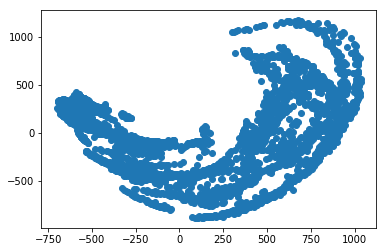

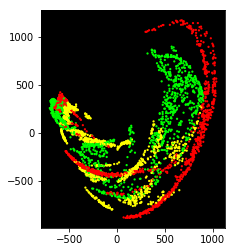

In [41]:
# Scatter plot ............ for 2 PCA - in Test set
plt.scatter(Xtpca2[:,0],Xtpca2[:,1])
print(Xtpca2.shape)


# Verify that they form three (mostly) separable clusters 

P = Xtpca2

print("Tt=", Tt.shape)
print("P=", P.shape)

label0=0  # Triangle
label1=1  # Square
label2=2  # Pizza

# Draw Scatter Plot
# For best effect, points should not be drawn in sequence but in random order
np.random.seed(0)
randomorder=np.random.permutation(np.arange(len(Tt)))
randomorder=np.arange(len(Tt))

# Set colors
cols=np.zeros((len(Tt),4))     # Initialize matrix to hold colors

for i,j in enumerate(Tt):
    if(j == label0): #Triangle
        cols[i]= [1,1,0,1] # 0 points are yellow (with opacity 0.25)
    elif(j == label1): #Square
        cols[i]= [1,0,0,1] # 1 points are red (with opacity 0.25)
    else:   #Pizza
        cols[i]= [0,1,0,1] # 2 points are green (with opacity 0.25)
        
#print("cols:",cols[1:20])

# Draw scatter plot
fig = plt.figure() #figsize=(8,8))
ax = fig.add_subplot(111, facecolor='black')
ax.scatter(P[randomorder,0],P[randomorder,1],s=5,linewidths=0,facecolors=cols[randomorder,:],marker="o");
ax.set_aspect('equal')

#plt.gca().invert_yaxis()
plt.show()

# Its not clearly separable clusters. we see lot of overlap between clusters

### Apply Logistic Regression to the Transformed PCA Components

In [109]:
# all parameters not specified, are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'
logisticRegr = LogisticRegression(solver = 'lbfgs',max_iter=10000,n_jobs=100,tol=0.00001,verbose=0, 
                                  warm_start=True)

### Apply Linear Classifiers - Logistic Regression on all 225 dims

In [34]:
#timeit -n1 -r1 (logisticRegr.fit(Xpca, T[:,0]).score(Xtpca, Tt[:,0]))

In [33]:
timeit -n1 -r1 (logisticRegr.fit(Xt, Tt[:,0]).score(X, T[:,0]))

968 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [110]:

#resLR = logisticRegr.fit(Xpca, T[:,0])- Reverse
#print("Logistic Regression fit done:", resLR) #0.78- Reverse
#resLR.score(Xtpca, Tt[:,0])- Reverse

print("X:, T:",X.shape, T.shape)
print("Xt:, Tt",Xt.shape, Tt.shape)
# Reverse Train and Test set

resLR = logisticRegr.fit(Xt, Tt[:,0])  # Fit all 225 dims
print("Logistic Regression fit done:", resLR) 
resLR.score(X, T[:,0])
#resLR.score(Xtpca, Tt[:,0]) # Check prediction on same training data


X:, T: (717, 225) (717, 1)
Xt:, Tt (4121, 225) (4121, 1)
Logistic Regression fit done: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr',
          n_jobs=100, penalty='l2', random_state=None, solver='lbfgs',
          tol=1e-05, verbose=0, warm_start=True)


0.9804741980474198

In [37]:
#LR_result = logisticRegr.predict(Xtpca)- Reverse
#print(LR_result.shape, LR_result)- Reverse

# Reverse Train and Test set
#LR_result = logisticRegr.predict(Xpca)
LR_result = logisticRegr.predict(X) # check predicton on all 196 dims
print(LR_result.shape, LR_result)


(717,) [1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 2 0 0 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 2 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 1
 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 2 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 2 2
 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 2 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 2 1 1 1 1 1 0 1 1 1 1 1 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 2 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 0 1 1

### Compare LR result with actuals

In [119]:

def compareResults(X,T):
    TP = 0;
    
    for i,val in enumerate(X):
        if(X[i] == T[i]):
            TP = TP + 1
    return [TP, len(X)]      
    
#print("Accuracy Results:", compareResults(LR_result,Tt))- Reverse
print("Accuracy Results:", compareResults(LR_result,T))

# Max Accuracy obtained is [4863, 10000]
        

Accuracy Results: [703, 717]


### Perceptron - Linear Classifier

In [112]:

# Build model with default init_params
perModel = linear_model.Perceptron(max_iter=1000,n_jobs=2,tol=0.0001, verbose=0, warm_start=False)

print("perModel:", perModel)

perModel: Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      max_iter=1000, n_iter=None, n_jobs=2, penalty=None, random_state=0,
      shuffle=True, tol=0.0001, verbose=0, warm_start=False)


In [113]:
timeit -n1 -r1 (perModel.fit(Xt, Tt[:,0]).score(X, T[:,0]))

116 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [114]:

# fit a perceptron Model with 3 components
res225 = perModel.fit(Xt, Tt[:,0]).score(X, T[:,0])

print("Perceptron fit done:", res225) # 0.40
#print("Perceptron coefficients:" , perModel.coef_)
print("Perceptron intercept:" , perModel.intercept_)

result225 = perModel.predict(X)

Perceptron fit done: 0.9818688981868898
Perceptron intercept: [ -6. -28.  24.]


### Separate out classes 

LR_result: [1 1 0 1 1]
P test sample count for class 0,1,2: 102 599 16


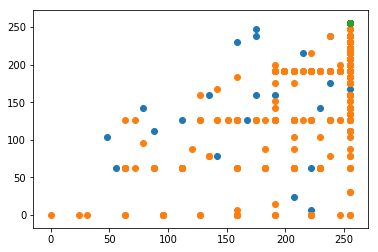

In [115]:
print("LR_result:",LR_result[0:5])

#[P1, P2, P3, P4, P5] = splitDataIntoClasses(Xtpca,LR_result) #- Reverse
[P1, P2, P3, P4, P5] = splitDataIntoClasses(X,result225) # check predicton on all 225 #196 dims

#[P1, P2, P3, P4, P5] = splitDataIntoClasses(Xpca,LR_result)

#print("Xtpca:" ,Xtpca.shape)

#print("P1:", P1[0:1])
#print("P2:" ,P2[0:1])
#print("P3:" ,P3[0:1])
print("P test sample count for class 0,1,2:", len(P1), len(P2), len(P3))

# Scatter plot ............
#plt.scatter(Pred[:,0],Pred[:,1])
plt.scatter(P1[:,0],P1[:,1])
plt.scatter(P2[:,0],P2[:,1])
plt.scatter(P3[:,0],P3[:,1])

In [116]:
# Separate out classes for actual distribution - in Train - Reverse

print("T:",T[0:5])

#[P1, P2, P3, P4, P5] = splitDataIntoClasses(Xtpca,LR_result)- Reverse
#[P1, P2, P3, P4, P5] = splitDataIntoClasses(Xpca,T) #LR_result)
[P1, P2, P3, P4, P5] = splitDataIntoClasses(X,T) # check predicton on all 225 #196 dims

#print("Xtpca:" ,Xtpca.shape)- Reverse
print("Xpca:" ,Xpca.shape)

#print("P1:", P1[0:1])
#print("P2:" ,P2[0:1])
#print("P3:" ,P3[0:1])
print("P test sample count for class 0,1,2:", len(P1), len(P2), len(P3))


T: [[1]
 [1]
 [0]
 [1]
 [1]]
Xpca: (717, 30)
P test sample count for class 0,1,2: 113 590 14


### Plot all classes from Testing set

Checking multiple testing vectors by plotting images.
Be patient:


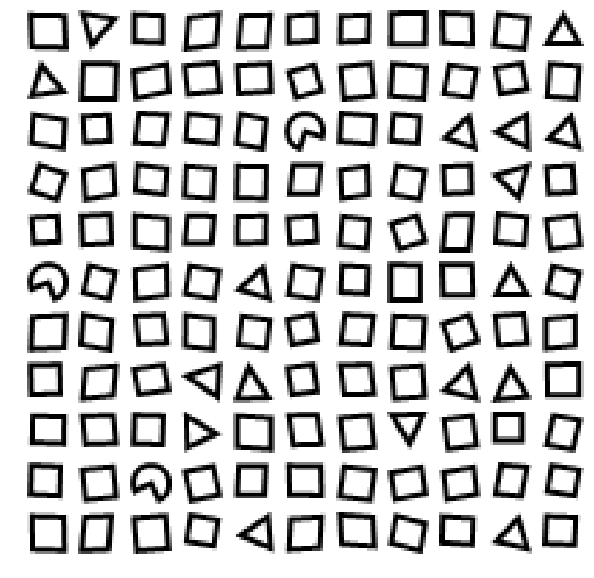

In [117]:
print("Checking multiple testing vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure(figsize=(10,10))
nrows=11
ncols=11
for row in range(nrows):
    for col in range(ncols):
        #print("row*ncols+col + 1", row*ncols+col + 1)
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        #vectortoimg(Xt[row*ncols+col + 1],show=False)- Reverse
        vectortoimgRed(X[row*ncols+col + 1],show=False)
plt.show()

### Plot results to visualize 3 class distribution

LR predicted class 0 result
Checking multiple training vectors by plotting images for class: 0 
Be patient:
T.shape (717,)


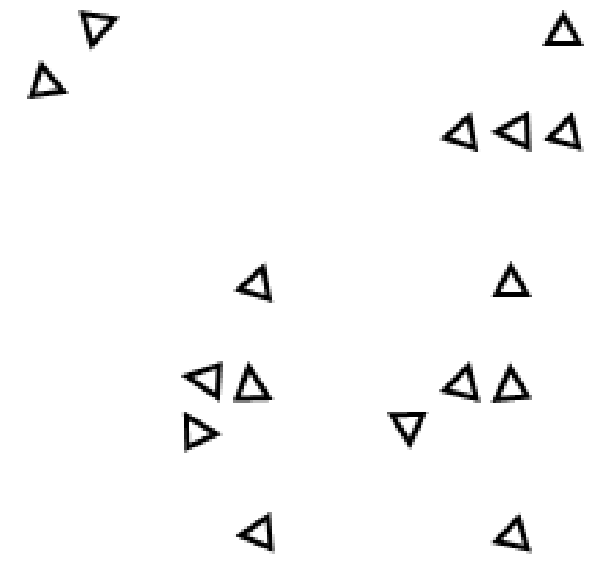

Actual class o result
Checking multiple training vectors by plotting images for class: 0 
Be patient:
T.shape (717, 1)


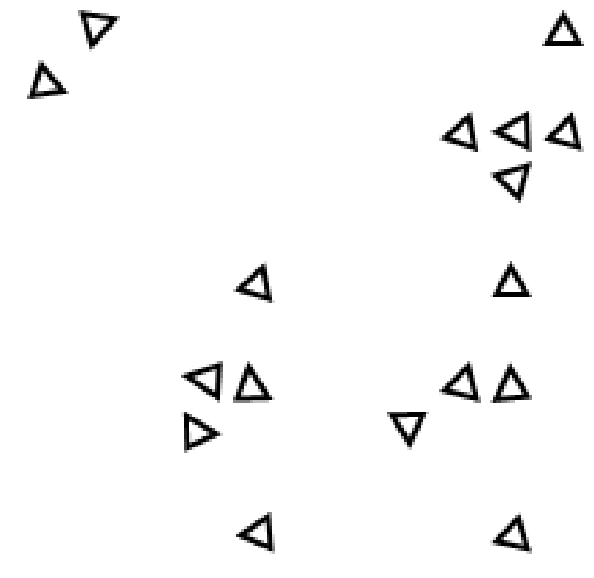

LR predicted class 1 result
Checking multiple training vectors by plotting images for class: 1 
Be patient:
T.shape (717,)


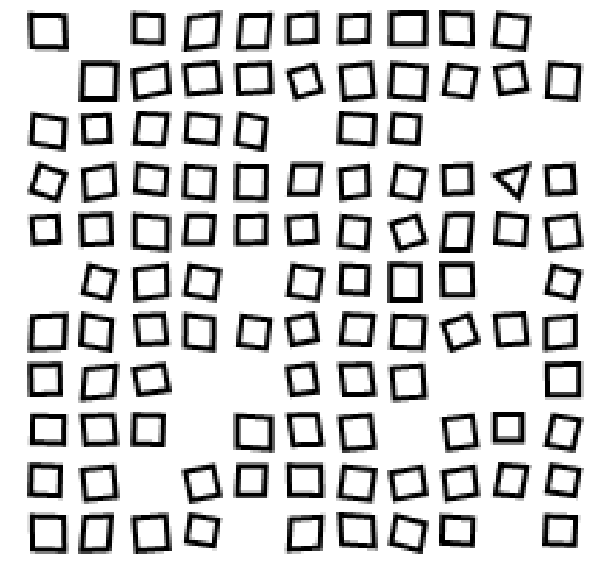

Actual class 1 result
Checking multiple training vectors by plotting images for class: 1 
Be patient:
T.shape (717, 1)


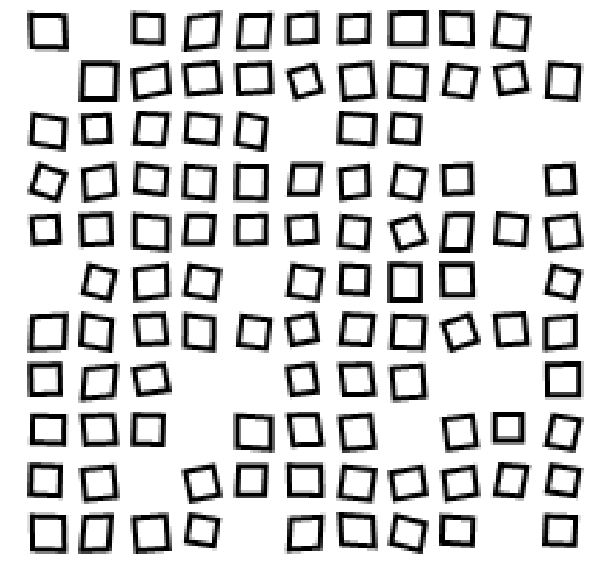

LR predicted class 2 result
Checking multiple training vectors by plotting images for class: 2 
Be patient:
T.shape (717,)


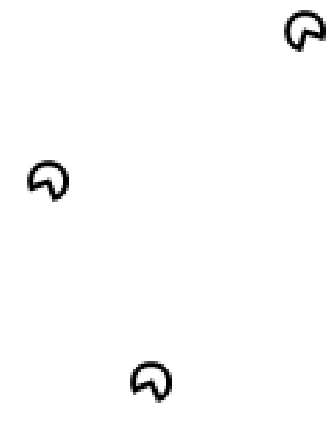

Actual class 2 result
Checking multiple training vectors by plotting images for class: 2 
Be patient:
T.shape (717, 1)


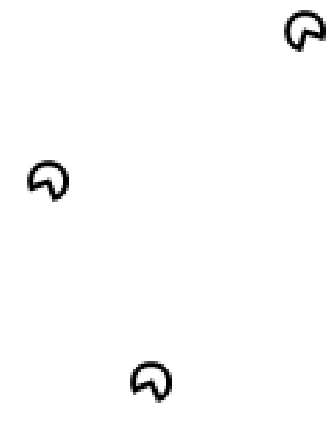

In [118]:
#Checking multiple training vectors by plotting images - for a class
def vectortoimgRedMlt(X,T,nrows,ncols,classLabel):
    print("Checking multiple training vectors by plotting images for class:",classLabel,"\nBe patient:")
    print("T.shape", T.shape)
    plt.close('all')
    fig = plt.figure(figsize=(10,10))
    for row in range(nrows):
        for col in range(ncols):
            if(classLabel == T[row*ncols+col + 1]):
                #print(T[row*ncols+col + 1], row*ncols+col + 1)
                plt.subplot(nrows, ncols, row*ncols+col + 1)
                vectortoimgRed(X[row*ncols+col + 1],show=False)
    plt.show()

    
print("LR predicted class 0 result") 
#vectortoimgMlt(Xt,LR_result,15,15,0) #- Reverse
vectortoimgRedMlt(X,result225,11,11,0)
print("Actual class o result")
#vectortoimgMlt(Xt,Tt,15,15,0) #- Reverse
vectortoimgRedMlt(X,T,11,11,0)

print("LR predicted class 1 result") 
#vectortoimgMlt(Xt,LR_result,15,15,1) #- Reverse
vectortoimgRedMlt(X,result225,11,11,1)
print("Actual class 1 result")
#vectortoimgMlt(Xt,Tt,15,15,1) #- Reverse
vectortoimgRedMlt(X,T,11,11,1)

print("LR predicted class 2 result") 
#vectortoimgMlt(Xt,LR_result,15,15,2) #- Reverse
vectortoimgRedMlt(X,result225,11,11,2)
print("Actual class 2 result")
#vectortoimgMlt(Xt,Tt,15,15,2) #- Reverse
vectortoimgRedMlt(X,T,11,11,2)


In [72]:
logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=10000,n_jobs=1,tol=0.0001, verbose=1, warm_start=True)

In [68]:
timeit -n1 -r1 (logisticRegr.fit(X, T[:,0]).score(Xt, Tt[:,0]))

/Users/monikabansal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
/Users/monikabansal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "


16min 20s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed: 16.3min finished


In [74]:


resLRnew = logisticRegr.fit(X, T[:,0])
print("Logistic Regression fit done:", resLRnew) # 75%
resLR.score(Xt, Tt[:,0])


Logistic Regression fit done: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=1, warm_start=True)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s finished


0.756

In [73]:
timeit -n1 -r1 (logisticRegr.fit(X, T[:,0]).score(Xt, Tt[:,0]))

4min 22s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min finished
